In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = 'C:/Users/PC/Documents/Jupyter/Segmentation/Brain_Segmentation'

In [4]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_masks')

x_valid_dir = os.path.join(DATA_DIR, 'valid')
y_valid_dir = os.path.join(DATA_DIR, 'valid_masks')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_masks')

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap='gray')
    plt.show()

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [7]:
os.listdir(x_train_dir)[1].split('.')[0]+'_mask.tif'

'TCGA_CS_4941_19960909_10_mask.tif'

In [14]:
class Dataset(BaseDataset):
    """
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['color_change']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id.split('.')[0]+'_mask.tif') for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = cv2.resize(image,(960,960))
        mask = cv2.imread(self.masks_fps[i],0)
#         mask = cv2.resize(mask,(960,960))

 
        
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask != v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
#         mask = mask.reshape(960,960)            
        return image, mask


        
    def __len__(self):
        return len(self.ids)

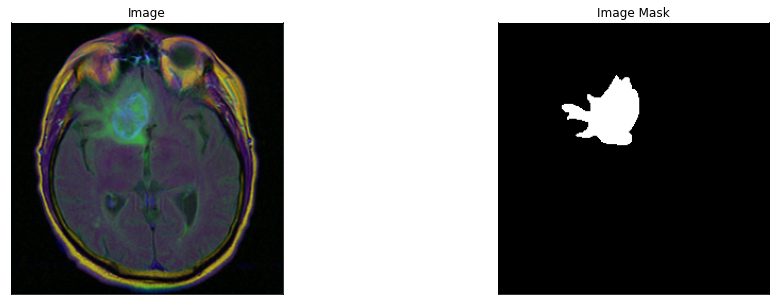

In [15]:

# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['color_change'])

image, mask = dataset[3] # get some sample
visualize(
    image=image, 
    image_mask=mask.squeeze(),
)

In [16]:
import albumentations as albu

In [17]:


def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):

    
    return x.transpose(2,0,1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


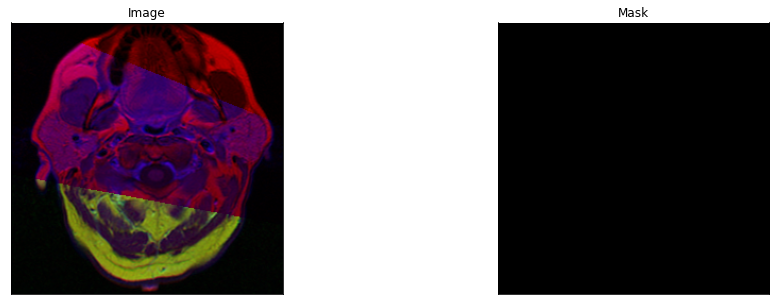

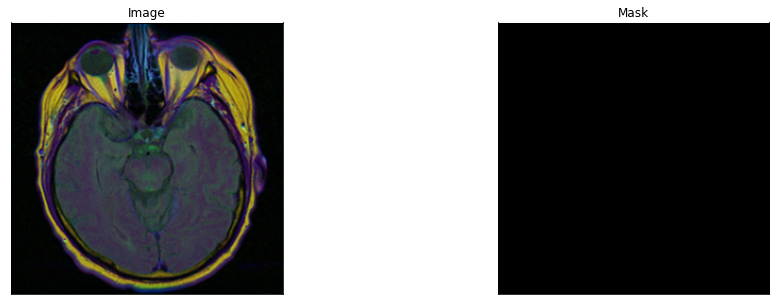

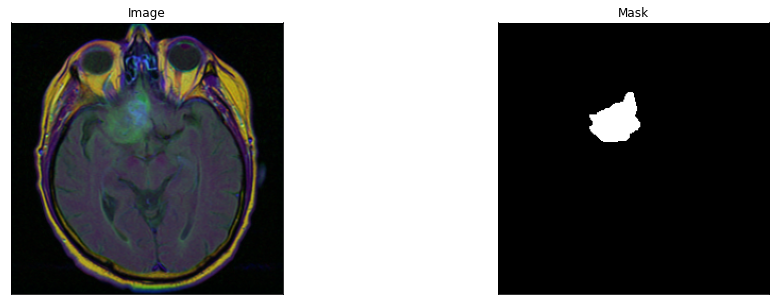

In [18]:


#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 

    classes=['color_change'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[i]
    visualize(image=image, mask=mask)

In [19]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [20]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['color_change']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.PSPNet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    in_channels=3,
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [21]:
a = []
for param in model.parameters():
    print(param.numel())
    a.append(param.numel())
    
    

9408
64
64
8192
128
128
4608
128
128
32768
256
256
4096
16
4096
256
16384
256
256
32768
128
128
4608
128
128
32768
256
256
4096
16
4096
256
32768
128
128
4608
128
128
32768
256
256
4096
16
4096
256
65536
256
256
18432
256
256
131072
512
512
16384
32
16384
512
131072
512
512
131072
256
256
18432
256
256
131072
512
512
16384
32
16384
512
131072
256
256
18432
256
256
131072
512
512
16384
32
16384
512
131072
256
256
18432
256
256
131072
512
512
16384
32
16384
512
262144
512
512
73728
512
512
524288
1024
1024
65536
64
65536
1024
524288
1024
1024
524288
512
512
73728
512
512
524288
1024
1024
65536
64
65536
1024
524288
512
512
73728
512
512
524288
1024
1024
65536
64
65536
1024
524288
512
512
73728
512
512
524288
1024
1024
65536
64
65536
1024
524288
512
512
73728
512
512
524288
1024
1024
65536
64
65536
1024
524288
512
512
73728
512
512
524288
1024
1024
65536
64
65536
1024
1048576
1024
1024
294912
1024
1024
2097152
2048
2048
262144
128
262144
2048
2097152
2048
2048
2097152
1024
1024
294912
1024

In [22]:
sum(a)

26303857

In [24]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir,

    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 

    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=0)

In [25]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [26]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [27]:
# train model for 20 epochs

max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 173/173 [00:03<00:00, 47.91it/s, dice_loss - 0.3026, iou_score - 0.6518]
Model saved!

Epoch: 1
valid: 100%|██████████| 173/173 [00:03<00:00, 47.79it/s, dice_loss - 0.2423, iou_score - 0.7161]
Model saved!

Epoch: 2
valid: 100%|██████████| 173/173 [00:03<00:00, 46.81it/s, dice_loss - 0.206, iou_score - 0.7411] 
Model saved!

Epoch: 3
valid: 100%|██████████| 173/173 [00:03<00:00, 47.75it/s, dice_loss - 0.2299, iou_score - 0.7292]

Epoch: 4
valid: 100%|██████████| 173/173 [00:03<00:00, 47.51it/s, dice_loss - 0.3291, iou_score - 0.6411]

Epoch: 5
valid: 100%|██████████| 173/173 [00:03<00:00, 47.76it/s, dice_loss - 0.2556, iou_score - 0.7063]

Epoch: 6
valid: 100%|██████████| 173/173 [00:03<00:00, 47.41it/s, dice_loss - 0.2331, iou_score - 0.7215]

Epoch: 7
valid: 100%|██████████| 173/173 [00:03<00:00, 48.03it/s, dice_loss - 0.2157, iou_score - 0.7367]

Epoch: 8
valid: 100%|██████████| 173/173 [00:03<00:00, 49.01it/s, dice_loss - 0.2018, iou_score - 0.7401